[colab](https://colab.research.google.com/github/rufous86/studies/blob/main/DLS_NLP/05_language_modeling/hw_language_modelling.ipynb)

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.1 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

from collections import Counter
from typing import List

import string


import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 1

import time

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(word_tokenize(x)) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


Посчитаем для каждого слова его встречаемость.

In [9]:
def count_words(dataset, remove_stops=False):
    words = Counter()
    if remove_stops:
        stops = stopwords.words('english')
    else:
        stops = []

    # Расчет встречаемости слов
    for example in tqdm(dataset):
        # Приводим к нижнему регистру и убираем пунктуацию
        processed_text = example.lower().translate(
            str.maketrans('', '', string.punctuation))
        processed_text = [
            word for word in word_tokenize(processed_text)
        ]

        for word in processed_text:
            words[word] += 1
    return words

words = count_words(dataset['train']['text'], remove_stops=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab_size = 40000

vocab = set(dict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]).keys())
for serv_word in ['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(serv_word)

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [16]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
def evaluate(model, criterion, dataloader) -> tuple[float, float]:
    model.eval()
    perplexity = []
    losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Validation'):
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1)) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten()).cpu().detach()
            perplexity.append(torch.exp(loss).item())
            losses.append(loss)
    
    perplexity = sum(perplexity) / len(perplexity)
    loss = sum(losses) / len(losses)

    return perplexity, loss.item()

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [18]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                algo_desc) -> dict:
    # Напишите код здесь
    start = time.time()
    losses = []
    perplexities = []
    val_losses = []
    val_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        epoch_perplexities = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(
                logits, batch['target_ids'].flatten())
            
            perplexity = torch.exp(loss).item()
            epoch_perplexities.append(perplexity)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(sum(epoch_perplexities) / len(epoch_perplexities))
        print('train_loss:', losses[-1])
        print('train_perplexity:', perplexities[-1])
            
        val_perplexity, val_loss = evaluate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        val_perplexities.append(val_perplexity)
        
        print('val_loss:', val_losses[-1])
        print('val_perplexity:', val_perplexities[-1])

    history = {
        'algo_desc': algo_desc,
        'train_loss': losses,
        'train_perplexity': perplexities,
        'val_loss': val_losses,
        'val_perplexity': val_perplexities,
        'execution_time': (time.time() - start) / num_epoch
        }
    return history

all_histories = []

Функция для вывода графиков

In [19]:
def plot_result(history):
    print(history['algo_desc'])
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'][1:], c='r', label='train')
    plt.plot(history['val_loss'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'loss, best on val {min(history["val_loss"]):.5f}')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_perplexity'][1:], c='r', label='train')
    plt.plot(history['val_perplexity'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'perplexity, best on val {min(history["val_perplexity"]):.5f}')
    
    plt.show()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [20]:
# class LanguageModelLinear(nn.Module):
#     def __init__(
#         self, embed_dim: int, 
#         hidden_dim: int, 
#         vocab_size: int,
#         num_layers: int,
#         gru_is_bidirectional: bool):
#         super().__init__()

#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         self.rnn = nn.GRU(embed_dim, 
#                           hidden_dim, 
#                           num_layers, 
#                           bidirectional=gru_is_bidirectional,
#                           batch_first=True)
        
#         if gru_is_bidirectional:
#             self.linear = nn.Linear(hidden_dim*2, hidden_dim)
#         else:
#             self.linear = nn.Linear(hidden_dim, hidden_dim)

#         self.projection = nn.Linear(hidden_dim, vocab_size)

#         self.non_lin = nn.Tanh()
#         self.dropout = nn.Dropout(p=0.1)

#     def forward(self, input_batch) -> torch.Tensor:
#         embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
#         x, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] 
#         x = self.dropout(self.linear(self.non_lin(x)))  # [batch_size, hidden_dim]
#         prediction = self.projection(self.non_lin(x))  # [batch_size, num_classes]

#         return prediction

In [21]:
# # Обучите модель здесь
# model = LanguageModelLinear(embed_dim=256, 
#                             hidden_dim=256, 
#                             vocab_size=len(vocab),
#                             num_layers=1,
#                             gru_is_bidirectional=False).to(device)
# criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
# optimizer = torch.optim.Adam(model.parameters())
# num_epoch = 10

# history1 = train_model(model, 
#                 train_dataloader, 
#                 eval_dataloader, 
#                 criterion, 
#                 optimizer, 
#                 num_epoch,
#                 'Language Model Linear с 1 GRU слоем')

# all_histories.append(history1)

Попробуем увеличить количество GRU слоев

In [22]:
# model = LanguageModelLinear(embed_dim=256, 
#                             hidden_dim=256, 
#                             vocab_size=len(vocab),
#                             num_layers=2,
#                             gru_is_bidirectional=False).to(device)
# criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
# optimizer = torch.optim.Adam(model.parameters())
# num_epoch = 10

# history2 = train_model(model, 
#                 train_dataloader, 
#                 eval_dataloader, 
#                 criterion, 
#                 optimizer, 
#                 num_epoch,
#                 'Language Model Linear с 2 GRU слоями')

# all_histories.append(history2)

Попробуем Bidirectional GRU

In [23]:
# # Обучите модель здесь
# model = LanguageModelLinear(embed_dim=256, 
#                             hidden_dim=256, 
#                             vocab_size=len(vocab),
#                             num_layers=1,
#                             gru_is_bidirectional=True).to(device)
# criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
# optimizer = torch.optim.Adam(model.parameters())
# num_epoch = 10

# history3 = train_model(model, 
#                 train_dataloader, 
#                 eval_dataloader, 
#                 criterion, 
#                 optimizer, 
#                 num_epoch,
#                 'Language Model Linear с Bidirectional GRU слоем')

# all_histories.append(history3)

Попробуем 2 слоя Bidirectional GRU

In [24]:
# model = LanguageModelLinear(embed_dim=256, 
#                             hidden_dim=256, 
#                             vocab_size=len(vocab),
#                             num_layers=2,
#                             gru_is_bidirectional=True).to(device)
# criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
# optimizer = torch.optim.Adam(model.parameters())
# num_epoch = 10

# history4 = train_model(model, 
#                 train_dataloader, 
#                 eval_dataloader, 
#                 criterion, 
#                 optimizer, 
#                 num_epoch,
#                 'Language Model Linear с 2 Bidirectional GRU слоями')

# all_histories.append(history4)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

Попробуем в первой модели с 1 слоем скрытого состояния и однонаправленным GRU добавить сверточный слой перед GRU

In [25]:
class LanguageModelConvBeforeGRU(nn.Module):
    def __init__(self, vocab_size: int, 
                 embed_dim: int, 
                 hidden_dim: int, 
                 kernel_size: int,
                 b_norm: bool):
        super().__init__()
        self.b_norm = b_norm
        self.norm = nn.BatchNorm1d(hidden_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, hidden_dim, kernel_size, padding='same')
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1) # swap dimensions for Conv1d
        x = self.conv(x)
        x = nn.functional.relu(x)

        if self.b_norm:
            x = self.norm(x)

        x = x.permute(0, 2, 1) # swap dimensions back
        x = x.squeeze(0)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x


In [26]:
# model = LanguageModelConvBeforeGRU(embed_dim=256, 
#                           hidden_dim=256, 
#                           vocab_size=len(vocab),
#                           kernel_size=3,
#                           b_norm=False).to(device)
# criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
# optimizer = torch.optim.Adam(model.parameters())
# num_epoch = 10

# history5 = train_model(model, 
#                 train_dataloader, 
#                 eval_dataloader, 
#                 criterion, 
#                 optimizer, 
#                 num_epoch,
#                 'Language Model Conv Before GRU')

# all_histories.append(history5)

Добавим слой батч нормализации после сверток

In [27]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 5

history6 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Conv Before GRU с батч нормализацией')

all_histories.append(history6)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

train_loss: 0.7038602577320099
train_perplexity: 119.2861421879318


Validation:   0%|          | 0/777 [00:00<?, ?it/s]

val_loss: 0.06217619404196739
val_perplexity: 1.0642409846282528


Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

train_loss: 0.03527283766276967
train_perplexity: 1.0361718182015207


Validation:   0%|          | 0/777 [00:00<?, ?it/s]

val_loss: 0.012665988877415657
val_perplexity: 1.01276641002493


Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

train_loss: 0.006424240149540358
train_perplexity: 1.0064556867195922


Validation:   0%|          | 0/777 [00:00<?, ?it/s]

val_loss: 0.005950327962636948
val_perplexity: 1.005982736056069


Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

train_loss: 0.0007603340087760441
train_perplexity: 1.0007608984136236


Validation:   0%|          | 0/777 [00:00<?, ?it/s]

val_loss: 0.005246566142886877
val_perplexity: 1.0052776207795013


Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

train_loss: 0.00022340626590123793
train_perplexity: 1.0002234408861193


Validation:   0%|          | 0/777 [00:00<?, ?it/s]

val_loss: 0.005155357997864485
val_perplexity: 1.0051861924707812


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

Language Model Conv Before GRU с батч нормализацией


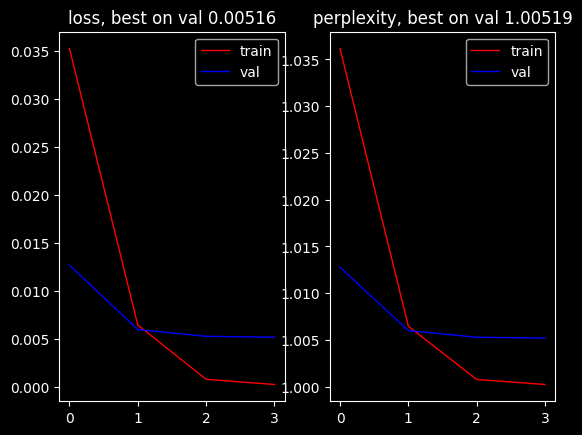

In [28]:
for history in all_histories:
    plot_result(history)

In [29]:
import pandas as pd

data = {
    'algo_desc': [],
    'val_perplexity': []
}

for history in all_histories:
    data['algo_desc'].append(history['algo_desc'])
    data['val_perplexity'].append(min(history['val_perplexity']))

pd.DataFrame(data).sort_values(by='val_perplexity', ascending=True)

,algo_desc,val_perplexity
0,Language Model Conv Before GRU с батч нормализ...,1.005186


Сравним время выполнения алгоритмов

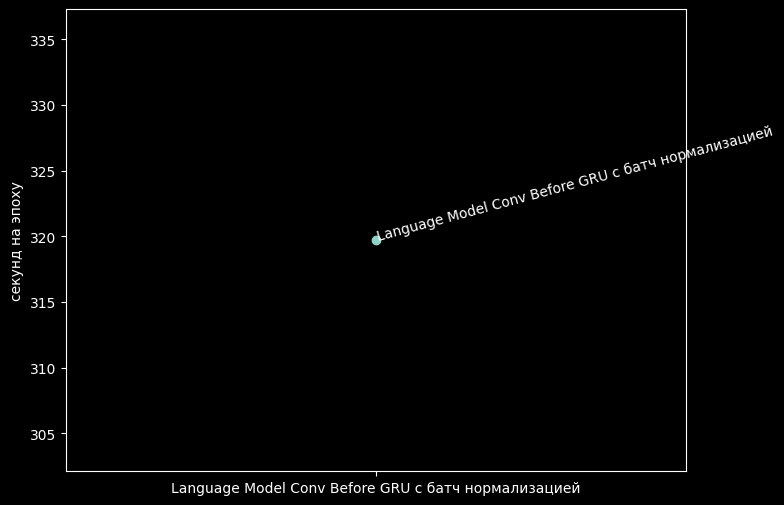

In [30]:
times = [(history['algo_desc'], history['execution_time']) for history in all_histories]

names, times = zip(*times)
plt.figure(figsize=(8, 6))
plt.scatter(names, times)

for name, time in zip(names, times):
    plt.annotate(name, (name, time), rotation=15)

plt.ylabel('секунд на эпоху')
plt.show()

Модели со сверточными слоями оказались не только с самой низкой перплексией, но и самыми быстрыми

Попробуем что-нибудь сэмплировать

In [31]:
# def generate_sequence(model, starting_seq: str, max_seq_len: int = 10) -> str:
#     device = 'cpu'
#     model = model.to(device)
#     input_ids = [word2ind['<bos>']] + [
#         word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
#     input_ids = torch.LongTensor(input_ids).to(device)

#     model.eval()
#     with torch.no_grad():
#         for i in range(max_seq_len):
#             next_word_distribution = model(input_ids)[-1]
#             next_word = next_word_distribution.squeeze().argmax()
#             input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

#             if next_word.item() == word2ind['<eos>']:
#                 break
    
#     words = ' '.join([ind2word[idx.item()] for idx in input_ids])

#     return words

# generate_sequence(model, starting_seq='some symphony came out ')

In [52]:
def generate_sequence_top_k(model, starting_seq: str, max_seq_len: int = 10, k: int = 10) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            top_k_values, top_k_indices = next_word_distribution.topk(k, dim=-1)
            next_word_probs = torch.softmax(top_k_values, dim=-1)
            next_word = torch.multinomial(next_word_probs, num_samples=1)
            print(next_word)
            input_ids = torch.cat((input_ids, next_word.unsqueeze(0)), dim=1)

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

generate_sequence_top_k(model, starting_seq='some symphony came out ')

tensor([0])


IndexError: ignored

In [36]:
torch.multinomial?